GBF - MAE: 0.6259985925555607
GBF - MSE: 0.795802611561682
GBF - MAPE: 0.09532974712255468
Epoch 10, Loss: 45.20606994628906
Epoch 20, Loss: 44.378318786621094
Epoch 30, Loss: 39.94454574584961
Epoch 40, Loss: 31.744550704956055
Epoch 50, Loss: 15.290879249572754
Epoch 60, Loss: 13.156964302062988
Epoch 70, Loss: 10.804985046386719
Epoch 80, Loss: 10.33626651763916
Epoch 90, Loss: 9.845684051513672
Epoch 100, Loss: 9.402188301086426
CNN - MAE: 2.510099172592163
CNN - MSE: 8.60803508758545
CNN - MAPE: 0.3746996223926544


D:\Anaconda\Application\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


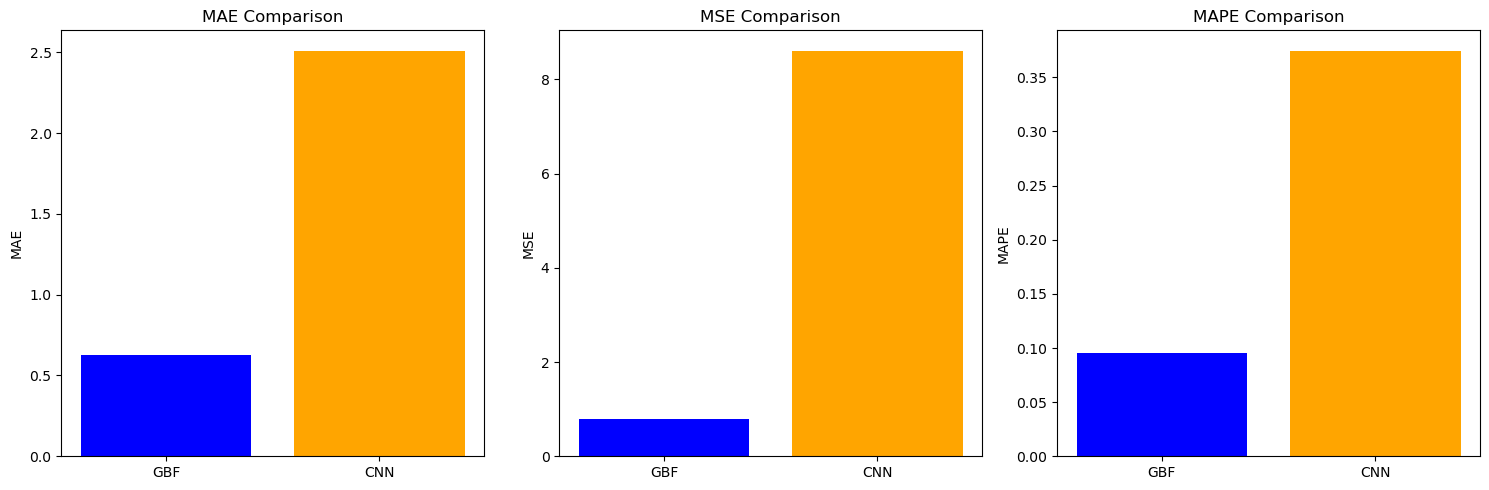

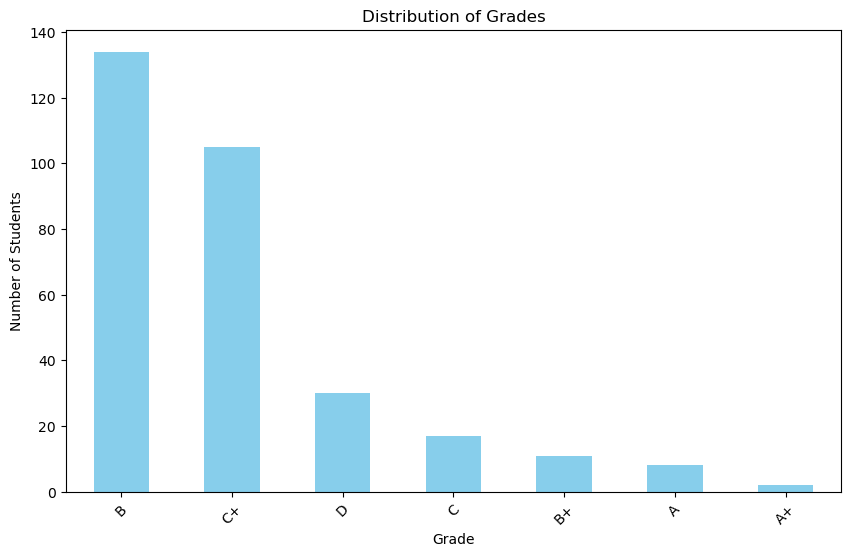

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('diemthi.csv')

# Xử lý dữ liệu: loại bỏ cột không chứa giá trị số và xử lý giá trị NaN
data = data.drop(['masv'], axis=1)
data.fillna(data.mean(), inplace=True)

# Tính điểm sinh viên
def compute_student_score(df):
    return (0.1 * df['diem10%.1'] + 0.1 * df['diem10%.2'] + 0.2 * df['diem20%'] + 0.6 * df['diemthi'])

# Áp dụng phân loại
def classify_score(score):
    if score >= 9:
        return 'A+'
    elif score >= 8.5:
        return 'A'
    elif score >= 8:
        return 'B+'
    elif score >= 7:
        return 'B'
    elif score >= 6:
        return 'C+'
    elif score >= 5:
        return 'C'
    else:
        return 'D'

# Augmentation function
def augment_data(X, y, augmentation_factor=0.1):
    noise = np.random.normal(0, augmentation_factor, X.shape)
    X_augmented = X + noise
    return np.vstack((X, X_augmented)), np.concatenate((y, y))

# Chuẩn bị dữ liệu
X = data.drop(['diemthi'], axis=1).values
y = data['diemthi'].values

# Áp dụng augmentation
X_augmented, y_augmented = augment_data(X, y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)

# Chia tập dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_augmented, test_size=0.2, random_state=42)

# Chuyển đổi dữ liệu thành float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# --------------------------------------
# 1. Mô hình Gradient Boosted Forest (GBF)
# --------------------------------------

# Tạo và huấn luyện mô hình GBF
gbf_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbf_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_gbf = gbf_model.predict(X_test)

# Đánh giá GBF
mae_gbf = mean_absolute_error(y_test, y_pred_gbf)
mse_gbf = mean_squared_error(y_test, y_pred_gbf)
mape_gbf = mean_absolute_percentage_error(y_test, y_pred_gbf)

print(f"GBF - MAE: {mae_gbf}")
print(f"GBF - MSE: {mse_gbf}")
print(f"GBF - MAPE: {mape_gbf}")

# --------------------------------------
# 2. Mô hình CNN với TensorFlow thuần
# --------------------------------------

# Khởi tạo trọng số ngẫu nhiên
def init_weights(shape):
    return tf.Variable(tf.random.normal(shape, stddev=0.01, dtype=tf.float32))

# Tạo mô hình CNN bằng cách sử dụng TensorFlow thuần
class CNNModel:
    def __init__(self):
        self.W1 = init_weights([3, 1, 32])  # kernel 3, input 1, output 32 filters
        self.W2 = init_weights([3, 32, 64])
        self.W3 = init_weights([X_train.shape[1]*64, 128])  # Fully connected layer
        self.W4 = init_weights([128, 1])  # Output layer
    
    def model(self, X):
        X = tf.nn.conv1d(X, self.W1, stride=1, padding='SAME')
        X = tf.nn.relu(X)
        X = tf.nn.conv1d(X, self.W2, stride=1, padding='SAME')
        X = tf.nn.relu(X)
        X = tf.reshape(X, [-1, X_train.shape[1]*64])
        X = tf.nn.relu(tf.matmul(X, self.W3))
        return tf.matmul(X, self.W4)

# Chuyển đổi định dạng cho TensorFlow
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Tạo mô hình
cnn_model = CNNModel()

# Khai báo optimizer và loss function
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Training function
def train_step(X, y):
    with tf.GradientTape() as tape:
        predictions = cnn_model.model(X)
        loss = tf.reduce_mean(tf.square(y - predictions))  # Sử dụng squared_error loss
    gradients = tape.gradient(loss, [cnn_model.W1, cnn_model.W2, cnn_model.W3, cnn_model.W4])
    optimizer.apply_gradients(zip(gradients, [cnn_model.W1, cnn_model.W2, cnn_model.W3, cnn_model.W4]))
    return loss

# Huấn luyện mô hình CNN
epochs = 100
for epoch in range(epochs):
    loss = train_step(X_train_cnn, y_train.reshape(-1, 1))
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

# Dự đoán với mô hình CNN
y_pred_cnn = cnn_model.model(X_test_cnn).numpy().flatten()

# Đánh giá CNN
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)

print(f"CNN - MAE: {mae_cnn}")
print(f"CNN - MSE: {mse_cnn}")
print(f"CNN - MAPE: {mape_cnn}")

# --------------------------------------
# Phân loại điểm
# --------------------------------------

# Tạo DataFrame để phân loại
df_classification = pd.DataFrame(data, columns=['diem10%.1', 'diem10%.2', 'diem20%', 'diemthi'])
df_classification['diemthi_pred'] = gbf_model.predict(scaler.transform(df_classification.drop(['diemthi'], axis=1)))
df_classification['score'] = compute_student_score(df_classification)
df_classification['grade'] = df_classification['score'].apply(classify_score)

# --------------------------------------
# Vẽ biểu đồ kết quả
# --------------------------------------

# Biểu đồ MAE, MSE, MAPE
metrics = {'MAE': [mae_gbf, mae_cnn], 'MSE': [mse_gbf, mse_cnn], 'MAPE': [mape_gbf, mape_cnn]}
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric_name, values) in enumerate(metrics.items()):
    ax[i].bar(['GBF', 'CNN'], values, color=['blue', 'orange'])
    ax[i].set_title(f'{metric_name} Comparison')
    ax[i].set_ylabel(metric_name)

plt.tight_layout()
plt.show()

# Biểu đồ phân loại
plt.figure(figsize=(10, 6))
grade_counts = df_classification['grade'].value_counts()
grade_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()
